# Exercise set 8

>The goal of this exercise is to perform **principal component analysis**
>and **clustering** on a data set with many variables.

## Exercise 8.1

This exercise will explore the [wine data set](https://archive.ics.uci.edu/ml/datasets/Wine), a data set commonly used as an example for classification.
The data set contains the results of
a chemical analysis of wines from a region in Italy. These
wines are made using grapes grown by three different cultivators.
In this first exercise, we will explore the
data set using principal component analysis and investigate
if the results from the chemical analysis can be used to separate
the wines into groups that correspond to the cultivator of the grapes.

The data set contains the following columns:


| Column name                    | Description                                              |
|--------------------------------|----------------------------------------------------------|
| alcohol                        | The alcohol content of the wine.                         | 
| malic_acid                     | The amount of malic acid in the wine (malic acid has an apple aroma).  |
| ash                            | The amount of ash in the wine (ash is the matter that remains after evaporation and incineration).   | 
| alcalinity_of_ash              | The alkalinity of the ash content of the wine.           |
| magnesium                      | The amount of magnesium in the wine.                      |
| total_phenols                  | The total amount of [phenols](https://en.wikipedia.org/wiki/Phenolic_content_in_wine) (that are not flavanoids) in the wine. |
| flavanoids                     | The amount of [flavanoids](https://en.wikipedia.org/wiki/Flavonoid) in the wine |
| nonflavanoid_phenols           | The total amount of phenols in the wine.   |
| proanthocyanins                | The amount of [proanthocyanins](https://en.wikipedia.org/wiki/Proanthocyanidin) in the wine (important for red/blue/purple colors).   |
| color_intensity                | Color intensity of the wine (measured spectroscopically).  |
| hue                            | Color hue of the wine (measured spectroscopically).         |
| od280/od315_of_diluted_wines   | The protein content of the wine. OD280/OD315 is a method for determining protein concentration.                                     |
| proline                        | The amount of [proline](https://en.wikipedia.org/wiki/Proline) in the wine (proline is the main amino acid found in red wine).   |  
| target                         | The cultivator of the wine, given as 0, 1, or 2.   |

The data can be loaded as follows:

In [1]:
"""Load the wine data set"""
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
import seaborn as sns

sns.set_theme(style="ticks", context="notebook", palette="muted")

%matplotlib inline

# Load the data set as a pandas frame:
data_set = load_wine(as_frame=True)["frame"]
data_set.head()


variables = [i for i in data_set.columns if i != "target"]

### 8.1(a)
Begin by exploring the raw data. Here, you should choose
the method yourself. You can, for instance, look at histograms of the
different measured quantities, correlations between the quantities,
or other plots of the raw data (for instance, the 
[scatter plot matrix](https://seaborn.pydata.org/examples/scatterplot_matrix.html) we used in a previous exercise). After looking at the raw data, are there some of the
variables that seem to be able to distinguish
between the wines produced by the different cultivators?

To make things a bit more interesting (and to show you how to make things slightly more interactive in a
Jupyter notebook); here are two examples that create a dropdown selector for picking variables:

In [2]:
from ipywidgets import interact, Dropdown

# This code shows the distributions for the three targets for one variable:

def show_data(variable):
    fig1, (ax1, ax2) = plt.subplots(constrained_layout=True, ncols=2, figsize=(8, 4))
    sns.boxplot(data=data_set, y=variable, x="target", ax=ax1)
    sns.kdeplot(data=data_set, x=variable, hue="target",
                fill=True, palette="muted", ax=ax2)
    


dropdown = Dropdown(options=variables, description="Variable:")
interact(show_data, variable=dropdown)

interactive(children=(Dropdown(description='Variable:', options=('alcohol', 'malic_acid', 'ash', 'alcalinity_o…

<function __main__.show_data(variable)>

In [3]:
# This is a 2D plot to show the distribution with two variables:

def show_data2(variable_x, variable_y):
    grid = sns.jointplot(
        data=data_set,
        x=variable_x,
        y=variable_y,
        hue="target",
        palette="muted",
    )

dropdown1 = Dropdown(options=variables, description="Variable X:")
dropdown2 = Dropdown(options=variables, description="Variable Y:")
interact(show_data2, variable_x=dropdown1, variable_y=dropdown2)

interactive(children=(Dropdown(description='Variable X:', options=('alcohol', 'malic_acid', 'ash', 'alcalinity…

<function __main__.show_data2(variable_x, variable_y)>

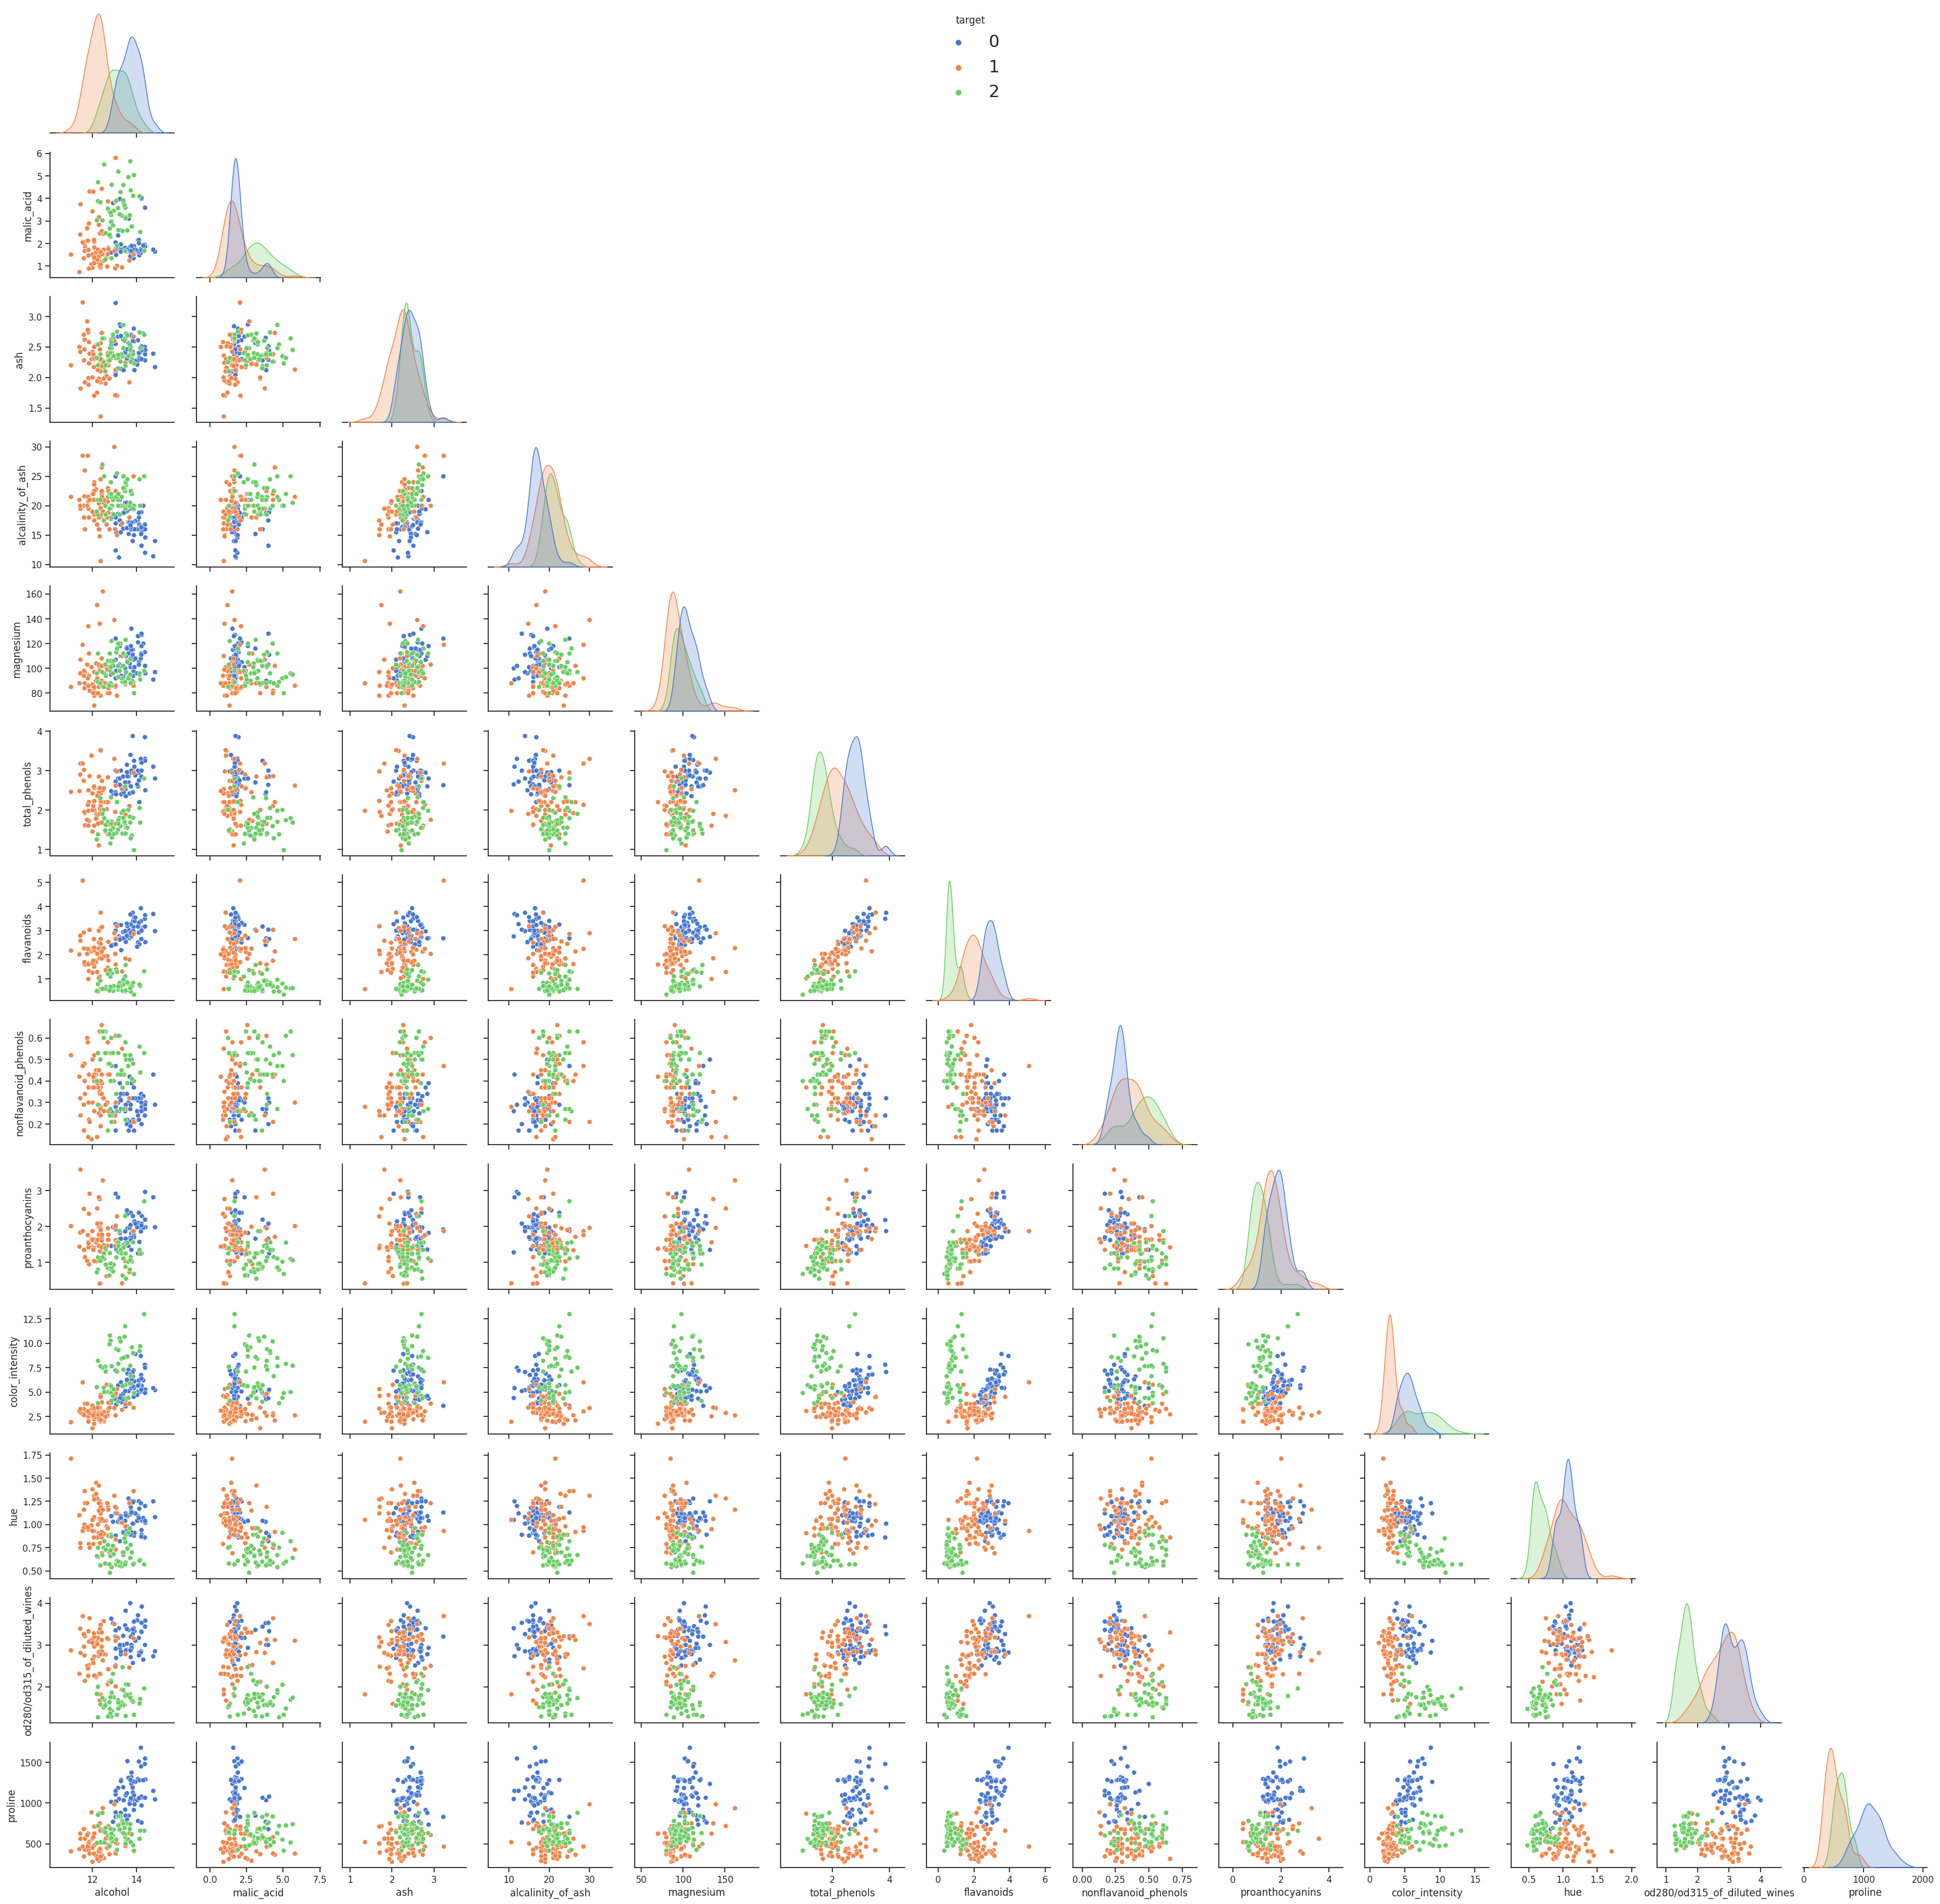

In [4]:
# For the exploring, we first try to make the scatter plot matrix:
grid = sns.pairplot(
    data_set,
    corner=True,
    hue="target",
    palette="muted",
)
grid.fig.tight_layout()
sns.move_legend(grid, "upper center", fontsize="xx-large")

<AxesSubplot: >

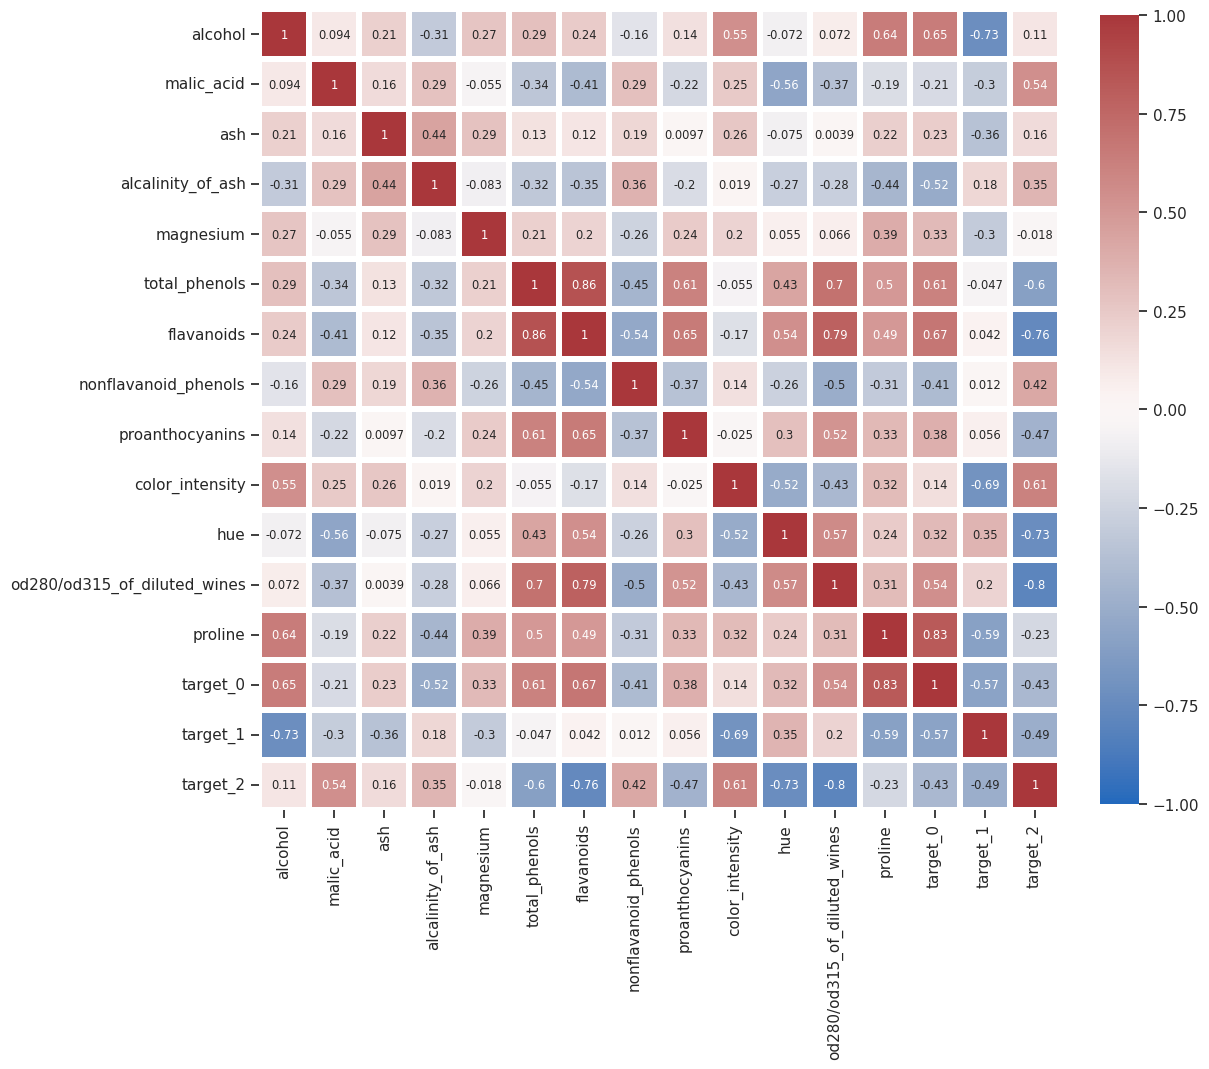

In [5]:
# Then a heatmap of correlations:
fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 12))
data2 = pd.get_dummies(data_set, columns=["target"])
sns.heatmap(
    data2.corr(),
    annot=True,
    ax=ax,
    fmt=".2g",
    annot_kws={"size": "x-small"},
    cbar_kws={"shrink": 0.75},
    linewidths=4,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="vlag",
)

In [6]:
# We can also try out some sklearn methods to pick the, say 4 best variables for
# distinguishing between the cultivators:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = data_set[variables]
y = data_set["target"]

select = SelectKBest(f_classif, k=4)  # Ask sklearn to do feature selection
X_select = select.fit_transform(X, y)
print(select.get_feature_names_out())

['alcohol' 'flavanoids' 'od280/od315_of_diluted_wines' 'proline']


#### Your answer to question 8.1(a): Did you find some variables that seem to distingush between cultivators?

Yes, from the scatter plot matrix, we see for instance the pairs:

* alcohol & flavanoids
* proline & hue
* proline & od280/od315_of_diluted_wines

The heatmap of correlations is more difficult to read here, but we see the same information
as in the scatter plot matrix (for instace, we see that proline is positively correlated
with cultivator 0, and negatively with the two other cultivators).

Finally, the "automatic" selection of the four most promising variables hightlights the same
variables as in the two figures. Let us just visualize some pairs of the most promising variables (so that we can compare this with the scores from PCA later): 

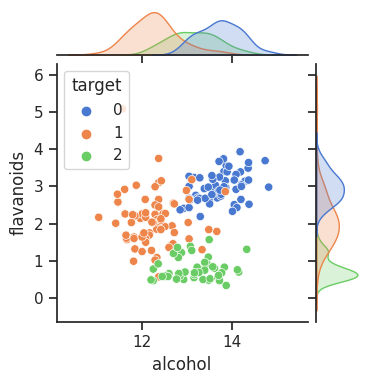

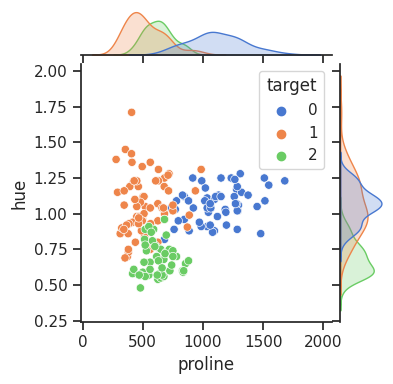

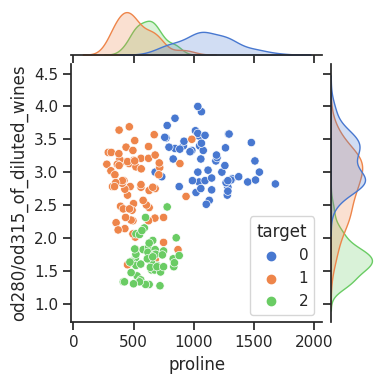

In [7]:
grid = sns.jointplot(
    data=data_set,
    x="alcohol",
    y="flavanoids",
    hue="target",
    palette="muted",
    height=4,
)
grid = sns.jointplot(
    data=data_set,
    x="proline",
    y="hue",
    hue="target",
    palette="muted",
    height=4,
)
grid = sns.jointplot(
    data=data_set,
    x="proline",
    y="od280/od315_of_diluted_wines",
    hue="target",
    palette="muted",
    height=4,
)

### 8.1(b)
Perform a PCA on the data set (see the example code 
for this below)
and consider the following:

* (i)  Do you need to scale your data before
  performing PCA in this case (why/why not)?


* (ii)  Should you include the `target` column in the data you use for the PCA?


* (iii)  How many principal components are needed to explain 95 % of the
  variance in the data? Answer this by plotting the explained variance
  as a function of the number of principal components.


Example code for PCA:

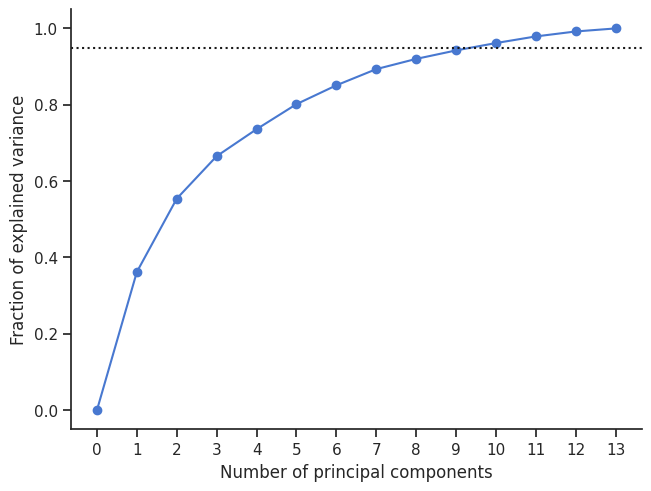

In [8]:
"""Load the wine data set and run PCA."""
from sklearn.datasets import load_wine
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA


data_set = load_wine(as_frame=True)["frame"]
variables = [i for i in data_set.columns if i != "target"]
X = data_set[variables].to_numpy()

# Uncomment the following line to scale your data:
X = scale(X)
pca = PCA()
scores = pca.fit_transform(X)

# Print out the percentage of variance explained by each component:
variance_ratio = pca.explained_variance_ratio_


fig1, ax1 = plt.subplots(constrained_layout=True)
variance = [0] + list(np.cumsum(pca.explained_variance_ratio_))
x = range(len(variance))
ax1.plot(x, variance, marker="o")
ax1.set(
    xlabel="Number of principal components",
    ylabel="Fraction of explained variance",
)
ax1.set_xticks(x)
ax1.axhline(y=0.95, ls=":", color="k")
sns.despine(ax=ax1)

#### Your answer to question 8.1(b):

> (i)  Do you need to scale your data before
  performing PCA in this case (why/why not)?

Here, we should scale the variables.
This ensures that we weight the different variables
equally when we perform PCA. There is no information given on the units, but from
the nature of the variables (they measure very different things) we expect
that the units will not all be equal.

> (ii)  Should you include the `target` column in the data you use for the PCA?

In this case we do not include the `target` column.
The reason for this is that we
are going to investigate if we can discover this distinction, without supplying the
information on the cultivars. This would be different if we were using a supervised
method, where we aim to predict the “target” column. We will later see classification
methods, and for such methods, we would use the `target` information as the 𝑦-values
we aim to predict.

> (iii)  How many principal components are needed to explain 95 % of the
  variance in the data? Answer this by plotting the explained variance
  as a function of the number of principal components.

From the plot above: We need 10 components to account for 95 % of the variance.

### 8.1(c)

* (i)  Rerun the PCA with
  the number of components you found in the previous question. Select the number of components with the argument
  `n_components` in `PCA()`, e.g. `pca = PCA(n_components=13)`,
  or, (for 95 % of the variance) `pca = PCA(n_components=0.95)`


* (ii)  Obtain the scores, and make a plot of the scores for
  principal component 1 (on the $x$-axis) and principal component 2 (on the $y$-axis).


* (iii)  Do you see any grouping(s) ("clusters") in your scores plot?
  Here, you can choose to color the scores according
  to the cultivator (i.e., by using the values in the `target`
  column in the data set).

In [9]:
# Example plot for the scores:
#fig, ax = plt.subplots()
#ax.scatter(scores[:, 0], scores[:, 1])  # Plot scores on first and second PC
# Example for coloring:
#fig, ax = plt.subplots()
#sns.scatterplot(x=scores[:, 0], y=scores[:, 1], hue=data_set["target"], palette="muted", ax=ax)

Number of components: 10


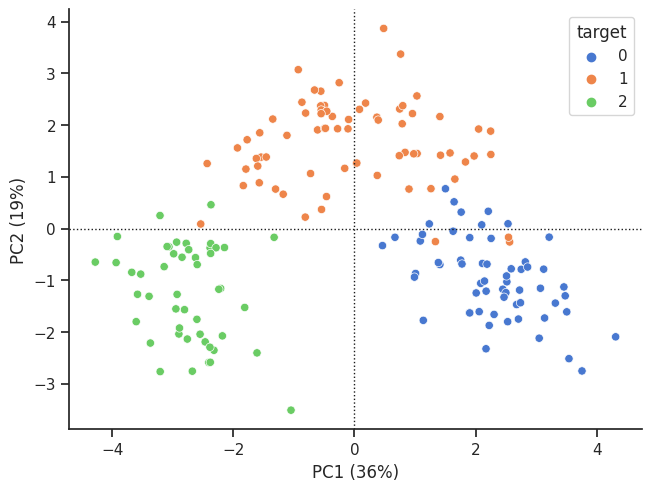

In [10]:
# (i)
pca = PCA(n_components=0.95)
scores = pca.fit_transform(X)
print("Number of components:", pca.n_components_)

# (ii)
fig1, ax1 = plt.subplots(constrained_layout=True)

sns.scatterplot(
    x=scores[:, 0],
    y=scores[:, 1], 
    hue=data_set["target"],
    palette="muted",
    ax=ax1,
)
var1 = pca.explained_variance_ratio_[0] * 100
var2 = pca.explained_variance_ratio_[1] * 100
ax1.set(
    xlabel=f"PC1 ({var1:.2g}%)",
    ylabel=f"PC2 ({var2:.2g}%)",
)
ax1.axhline(y=0, ls=":", lw=1, color="k")
ax1.axvline(x=0, ls=":", lw=1, color="k")
sns.despine(ax=ax1)

#### Your answer to question 8.1(c):

> (iii)  Do you see any grouping(s) ("clusters") in your scores plot?
  Here, you can choose to color the scores according
  to the cultivator (i.e., by using the values in the `target`
  column in the data set).
  
Yes, there is a grouping of the points that correspond to the cultivators.

### 8.1(d)
Explore the loadings for your PCA model by plotting the
loadings for the variables (on principal component 1 and
principal component 2). Are any of the variables correlated?

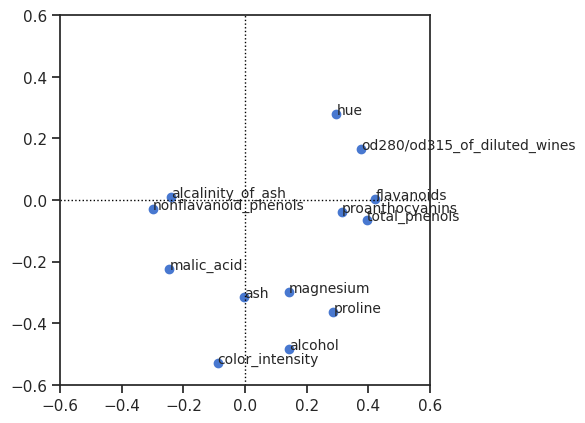

In [11]:
# The loadings are stored as the transpose in pca.components_
# The loadings for PC1 is:
load1 = pca.components_[0, :]
# The loadings for PC2 is:
load2 = pca.components_[1, :]

# Aternatively:
#loadings = pca.components_.T
#load1 = loadings[:, 0]
#load2 = loadings[:, 1]

# Example plot:
fig, ax = plt.subplots()
ax.axhline(y=0, ls=":", color="black", lw=1)
ax.axvline(x=0, ls=":", color="black", lw=1)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_aspect("equal")

# Just plotting the points:
ax.scatter(load1, load2)

# Adding text (name of variables):
for i, variablei in enumerate(variables):
    ax.text(load1[i], load2[i], variablei, fontsize="small")
    
# Here, you can probably make the plot easier to read. Maybe it should be bigger,
# more colorful, or maybe interactive like in the appedix in exercise 7?

In [12]:
# Here we will add some colors:
colors = sns.color_palette("husl", len(variables))
colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9218528551477546, 0.5003454332640002, 0.1960624705339954),
 (0.756593795426372, 0.58660455674609, 0.19460548454202936),
 (0.6280838378584804, 0.6317149736053096, 0.19371846323785552),
 (0.44127702936426016, 0.6747986506725627, 0.19278677787286805),
 (0.19925855442314272, 0.6935861010390585, 0.4349484671340832),
 (0.20730980534421067, 0.6820252887361699, 0.5931178995944008),
 (0.213603436221035, 0.6724447149771248, 0.6900417229996091),
 (0.2218708221705632, 0.6590814541823624, 0.7990680761766646),
 (0.38670894369284947, 0.6148978276981065, 0.9585912355668605),
 (0.7049741506310939, 0.5248938690186019, 0.9581527270311664),
 (0.9538763597142671, 0.3594595647605631, 0.95756585161213),
 (0.9637107389395935, 0.4095260281088575, 0.7436447221919831)]

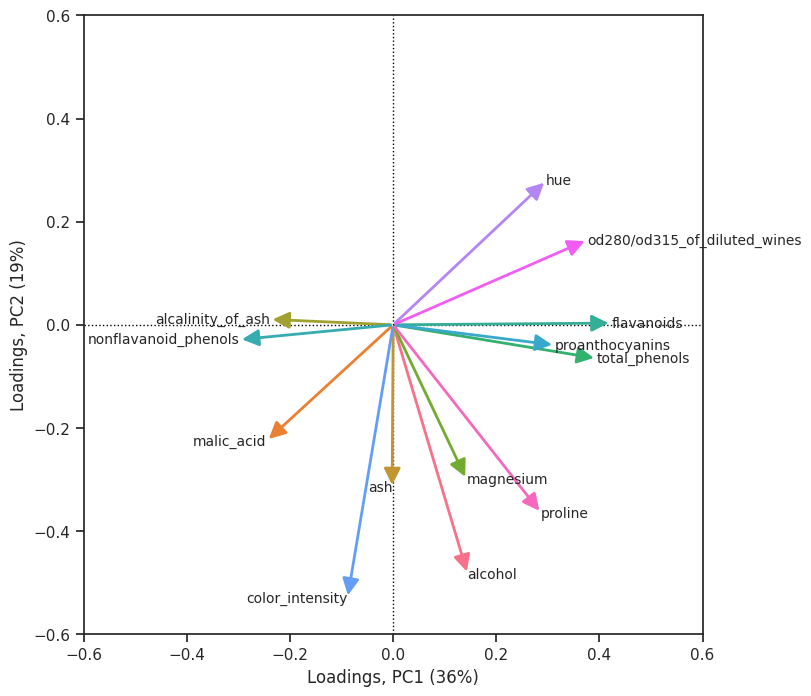

In [13]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
ax.axhline(y=0, ls=":", color="black", lw=1)
ax.axvline(x=0, ls=":", color="black", lw=1)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_aspect("equal")
ax.set(
    xlabel=f"Loadings, PC1 ({var1:.2g}%)",
    ylabel=f"Loadings, PC2 ({var2:.2g}%)",
)

# Adding text (name of variables):
for i, variablei in enumerate(variables):
    x, y = load1[i], load2[i]
    ha = "right" if x < 0 else "left"
    ax.text(x, y, variablei, fontsize="small", ha=ha, va="center")
    ax.annotate(
                "",
                xy=(x, y),
                xytext=(0, 0),
                arrowprops=dict(
                    arrowstyle="-|>", lw=2, color=colors[i], mutation_scale=25
                ),
                zorder=2,
            )

#### Your answer to question 8.1(d):

From the plot of the loadings above, we see that `flavanoids`, `total_phenols`, and `proanthocyanins` are grouped and (positively) correlated. Both
flavonoids and proanthocyanins are polyphenolic compounds so this is not so surprising.
The `nonflavanoid_phenols` is negatively correlated (points in the opposite direction)
with `flavanoids` (and `total_phenols`). This could indicate that wines with a higher
phenol content will have more polyphenolic compounds.

We also see that `alcalinity_of_ash` and `nonflavanoid_phenols` are positively correlated, and `malic_acid` and `hue` are negatively correlated. Here, I do not have a good chemical
explanation - please let me know if this makes sense to you!


We also note that the
loadings are of similar size (so that the principal components can not be described by just
a few of the original variables).

### 8.1(e)
Save the scores for the first two principal components.
We will use this information in the next part
of the exercise, where we will try to find clusters in our data.
Saving the scores can be
done with `pandas` as follows:

In [14]:
# Assuming that the scores are in the matrix scores, you can
# do the following to save the data (remember to limit to the first
# two PCs):

data_set = load_wine(as_frame=True)["frame"]
variables = [i for i in data_set.columns if i != "target"]
X = scale(data_set[variables].to_numpy())
pca = PCA(n_components=2)
scores = pca.fit_transform(X)


# 1. Create variable names for the principal components:
pc_name = [f"PC{i+1}" for i in range(scores.shape[1])]
# 2. Create a DataFrame from the scores:
scores_data = pd.DataFrame(scores, columns=pc_name)
scores_data["target"] = data_set["target"]
# 3. Save the scores to a comma separated values-file:
scores_data.to_csv("scores.csv", index=False)

# Note, here you could also save it into many other formats,
# for instance, Excel:
#scores_data.to_excel("scores.xlsx", index=False)
# or maybe as LaTeX for a report:
#print(scores_data.style.to_latex())

After running the code below, the file should be available here: [scores.csv](./scores.csv)

In [15]:
# Let us check that the file is present:
my_data = pd.read_csv("scores.csv")
my_data.head()

,PC1,PC2,target
0,3.316751,-1.443463,0
1,2.209465,0.333393,0
2,2.516740,-1.031151,0
3,3.757066,-2.756372,0
4,1.008908,-0.869831,0


## Exercise 8.2

We will continue exploring the wine data set. We will pretend that we do not
know that there are three cultivators in the data set, and we will investigate
what the `KMeans` clustering method can tell us about it. For this
exercise, it is a good idea to read through all points below before
starting, since you will do the same analysis twice (first for the complete data set,
and then for the PCA scores you saved in part [8.1(e)](#8.1(e))).

### 8.2(a)
Outline the steps in the `KMeans` clustering algorithm.
How can we use this algorithm without knowing the number of clusters in the data?

#### Your answer to question 8.2(a):

The KMeans clustering starts with first defining the number of clusters we are going to find.
Then we find initial positions for our centroids. This can, for instance, be done by giving the
centroids random positions.

After having set the initial positions of the clusters, we do the following:

1. For each observation (data point) we assign it to the nearest centroid.


2. For each centroid, we calculate a new center by taking the mean of the locations of
   the observations assigned to it in the previous step.


3. We update the locations for the centroids according to the mean found in the previous
   step.


4. We repeat the steps above until the locations of the cluster centers do not change.


If we do not know how many clusters there are, we have to try different values. After
trying different possible cluster numbers, we compare them using metrics such as the sum
of squared distances of the samples to their closest cluster center, or the silhouette values.

### 8.2(b)
Run `KMeans` clustering on the wine data set (see the example code below).
Here, you will have to
select a set of numbers of clusters to look for (limit yourself to
a maximum of 10 clusters).

After running the clustering for your 
data, obtain and plot the following metrics:

* (i) The sum of squared distances of the samples to
  their closest cluster center as a function of the number of clusters considered.
  
  
* (ii) The average silhouette value as a function of the number of clusters considered. (Note:
  if you want to plot the distribution of silhouette values (not required here!), take
  a look at this
  [silhouette example](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html).)


* (iii) The Gap statistic as a function of the number of clusters considered. (Skip this point if you are unable to install [gapstap](https://github.com/jmmaloney3/gapstat) - see the instructions below).

Explain briefly (with a few lines of text) how you use these plots to identify the "best" number of clusters and use them to decide how many clusters there are in the wine data set.

The cells below show Python code that runs the clustering and calculates the metrics to get you started.

In [16]:
"""Load the wine data set and run KMeans."""
from sklearn.datasets import load_wine
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


data_set = load_wine(as_frame=True)["frame"]
variables = [i for i in data_set.columns if i != "target"]
X_wine = scale(data_set[variables].to_numpy())
# We scale the variance here (you have probably already
# figured out this is a good idea during the PCA part in 8.1.)

# Define a set of numbers of clusters to run KMeans for:
number_of_clusters = range(1, 11)
# Set up variables for storing the results
results = []  # Results for the clustering

for i in number_of_clusters:
    # Set up the KMeans method with i cluster centers:
    cluster_k = KMeans(n_clusters=i)
    # Run the clustering method:
    cluster_k.fit(X)
    # Store the results:
    results.append(cluster_k)

Note that the `cluster_k` object contains the following results as attributes:
 * `cluster_centers_`: Coordinates of cluster centers.
 * `labels_`: Labels of each sample. Each sample is assiged to a cluster, and the label shows which cluster a sample belongs to. Note that these are just
    labels - the actual numbers (0, 1, ...) do not have any meaning except being a label.
 * `inertia_`: Sum of squared distances of samples to their closest cluster center.
 * `n_iter_`: Number of iterations run.
 
The silhouette values can be calculated with [sklearn.metrics.silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), and
the Gap statistic can be obtained via the [gapstat](https://github.com/jmmaloney3/gapstat) package. If you do not have this one installed, you can install it via:

```bash
pip install git+https://github.com/jmmaloney3/gapstat
```

In [17]:
# Uncomment the line below to install gapstat:
# !pip install git+https://github.com/jmmaloney3/gapstat
from gapstat import gapstat_score

In [18]:
def run_clustering(X, k_max=10):
    """Run clustering for the data set in X."""
    number_of_clusters = range(1, k_max + 1)
    clusters = []
    for i in number_of_clusters:
        cluster_k = KMeans(n_clusters=i)
        cluster_k.fit(X)
        clusters.append(cluster_k)
    return clusters    

In [19]:
from tqdm.notebook import tqdm  # For fun, add a progress bar!

def calculate_sse(clusters):
    return np.array([(i.n_clusters, i.inertia_) for i in tqdm(clusters)])


def calculate_silhouette(clusters, X):
    results = []
    for i in tqdm(clusters):
        if i.n_clusters < 2:
            sil = float("nan")           
        else:
            sil = silhouette_score(X, i.labels_)
        results.append([i.n_clusters, sil])
    return np.array(results)


def calculate_gap(clusters, X):
    results = []
    for i in tqdm(clusters):
        gapi, _, _, _, err = gapstat_score(
            X, i.labels_, k=i.n_clusters, calcStats=True
        )
        results.append([i.n_clusters, gapi, err])
    return np.array(results)


def plot_cluster_metrics(clusters, X):
    
    print("Calculate SSE...")
    sse = calculate_sse(clusters)

    print("Calculate silhouette...")
    silhouette = calculate_silhouette(clusters, X)

    print("Calculate Gap")
    gap = calculate_gap(clusters, X)

    fig, axes = plt.subplots(constrained_layout=True, ncols=3, figsize=(9, 3), sharex=True)
    axes[0].plot(sse[:, 0], sse[:, 1], marker="o")
    axes[0].set_xticks(sse[:, 0])
    axes[0].set(ylabel="SSE")
    
    axes[1].plot(silhouette[:, 0], silhouette[:, 1], marker="o")
    axes[1].set(ylabel="Average silhouette")
    
    axes[2].errorbar(gap[:, 0], gap[:, 1], yerr=gap[:, 2], marker="o", capsize=4, elinewidth=2)
    axes[2].set(ylabel="Gap statistic")
    
    for axi in axes:
        axi.set(xlabel="Number of clusters")
    
    sns.despine(fig=fig)

    return fig

In [20]:
clusters_wine = run_clustering(X_wine, k_max=10)

Calculate SSE...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculate silhouette...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculate Gap


  0%|          | 0/10 [00:00<?, ?it/s]

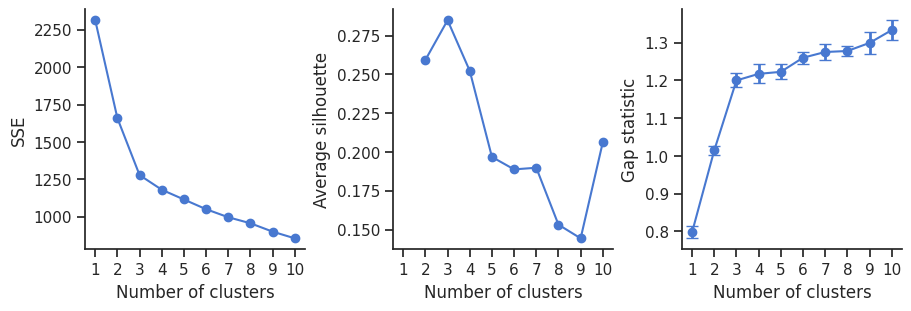

In [21]:
figcluster = plot_cluster_metrics(clusters_wine, X_wine)

#### Your answer to question 8.2(b): What seems to be the best number of clusters to use?

Hard to say! In the plot of the sum of squared distances, there is no
clear “elbow”, however, we see that there is a
large drop when going from 2 to 3 clusters, and smaller drops when increasing the number
of clusters. We can take this as an indication of there being three clusters in the data
set. (The drop from 3-4 is about the same as between 4-5 and so on, so if we do not stop
at 3, then we should continue on to around 8).

The silhouette plot shows a maximum at three clusters. This indicates that there are
three clusters in the data.

The Gap statistic levels off around three clusters, but it keeps on increasing. However,
the change from 3 to 4 is small and it makes sence to stop at 3 clusters (it is just within
the errorbar at 4 clusters).

Based on these three plots together, there seems to be three clusters in the data set.
The strongest point for this is made by the average silhouette plot.

### 8.2(c)
The clustering you just have done used all the variables. Visualizing the clusters (and potential regions for the different types) in
this 13-dimensional space is difficult! We will therefore use the scores from the principal
component analysis where we just stored two components. This means
that we now have a 2-dimensional problem!

Rerun the cluster analysis for the scores (again, vary the number of clusters)
and make the same plots as you made in [8.2(b)](#8.2(b)). What is the
best number of clusters to use now? Are your results different from the
cluster analysis on the full data set, and how does it compare to
what we know - that the samples come from three different cultivators of wine?

In [22]:
scores = pd.read_csv("scores.csv")
X_scores = scores[["PC1", "PC2"]].to_numpy()

In [23]:
clusters_scores = run_clustering(X_scores, k_max=10)

Calculate SSE...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculate silhouette...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculate Gap


  0%|          | 0/10 [00:00<?, ?it/s]

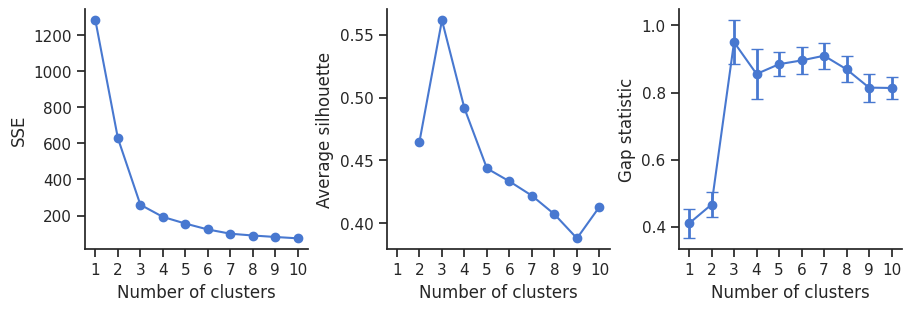

In [24]:
figcluster2 = plot_cluster_metrics(clusters_scores, X_scores)

#### Your answer to question 8.2(c):

In this case, the results are more clear and there is
a pronounced peak in the silhouette values for three clusters. The Gap statistic is
also largest for three clusters. The SSE is again less defined, but the two other agree
on there being three clusters. 

The PCA component analysis resulted in new variables that are better
suited for distinguishing between the cultivators.
We conclude that there are three clusters in the data set, and this is what we know
from before (there are three cultivators).

### 8.2(d) Bonus: Showing the decision regions.
Since we reduced the problem to two dimensions in [8.2(c)](#8.2(c)), we
can plot the clusters. Here, we can also plot the so-called decision
regions, which show the areas that belong to each cluster. Use the code below
to show the decision regions for the best clustering you found in [8.2(c)](#8.2(c)).

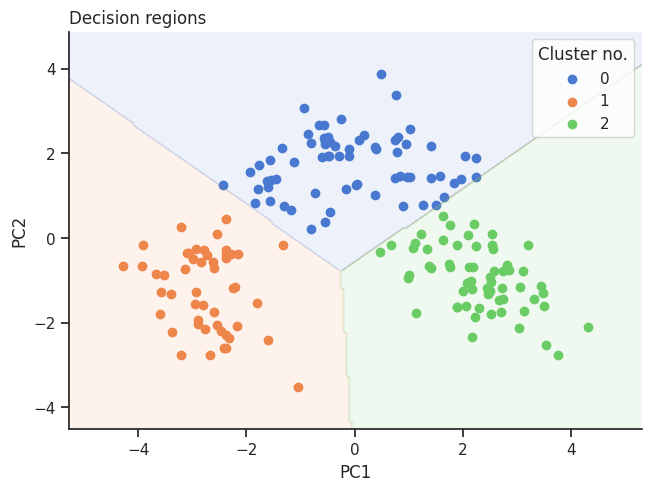

In [25]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib

cluster = KMeans(n_clusters=3).fit(X_scores) 

y = cluster.labels_  # Use the assigned labeles

fig, ax = plt.subplots(constrained_layout=True)
ax.set(xlabel="PC1", ylabel="PC2")
# Show the samples:
colors = []
for i in sorted(set(y)):
    scat = ax.scatter(X_scores[y == i, 0], X_scores[y == i, 1], label=i)
    colors.append(scat.get_facecolors())  # Store colors, so we can reuse them
# Draw the boundaries:
cmap = matplotlib.colors.ListedColormap(colors)  # Use same colors
DecisionBoundaryDisplay.from_estimator(
    cluster,
    X_scores,
    grid_resolution=200,
    ax=ax,
    cmap=cmap,
    alpha=0.1,
)
ax.legend(title="Cluster no.")
ax.set_title("Decision regions", loc="left")
sns.despine(fig=fig)